#  Model Diagnostics for Teenage Gambling Data"

In [2]:
knitr::opts_chunk$set(echo = TRUE, 
                      warning = FALSE, 
                      message = FALSE)

## Introduction

This mini-project explores a linear regression model fitted to the `teengamb` dataset from the **faraway** R package. The goal is to diagnose potential violations of model assumptions, such as constant variance, normality of residuals, as well as to detect leverage points, outliers, and influential observations.

<br>

## Data and Model

We begin by loading the necessary packages and fitting our linear model (`lmod`) predicting annual gambling expenditure (`gamble`) as a function of sex, socioeconomic status (`status`), weekly income, and verbal score (`verbal`).

In [3]:
# Load required libraries
library(faraway)
library(car) # For avPlots, crPlots

# Fit the linear model
lmod <- lm(gamble ~ ., data = teengamb)
summary(lmod)

Loading required package: carData


Attaching package: ‘car’


The following objects are masked from ‘package:faraway’:

    logit, vif





Call:
lm(formula = gamble ~ ., data = teengamb)

Residuals:
    Min      1Q  Median      3Q     Max 
-51.082 -11.320  -1.451   9.452  94.252 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  22.55565   17.19680   1.312   0.1968    
sex         -22.11833    8.21111  -2.694   0.0101 *  
status        0.05223    0.28111   0.186   0.8535    
income        4.96198    1.02539   4.839 1.79e-05 ***
verbal       -2.95949    2.17215  -1.362   0.1803    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 22.69 on 42 degrees of freedom
Multiple R-squared:  0.5267,	Adjusted R-squared:  0.4816 
F-statistic: 11.69 on 4 and 42 DF,  p-value: 1.815e-06


**Interpretation of model summary**  
- **sex** appears significant (with negative coefficient, meaning females spend less than males on gambling).
- **income** is the most significant predictor, strongly associated with gambling expenditure.
- **status** and **verbal** appear not to be statistically significant in this model.

<br>

## Checking the Constant Variance Assumption

A fundamental assumption of linear regression is that the variance of the residuals (errors) is constant (homoscedasticity). We first use a residuals-versus-fitted-values plot:

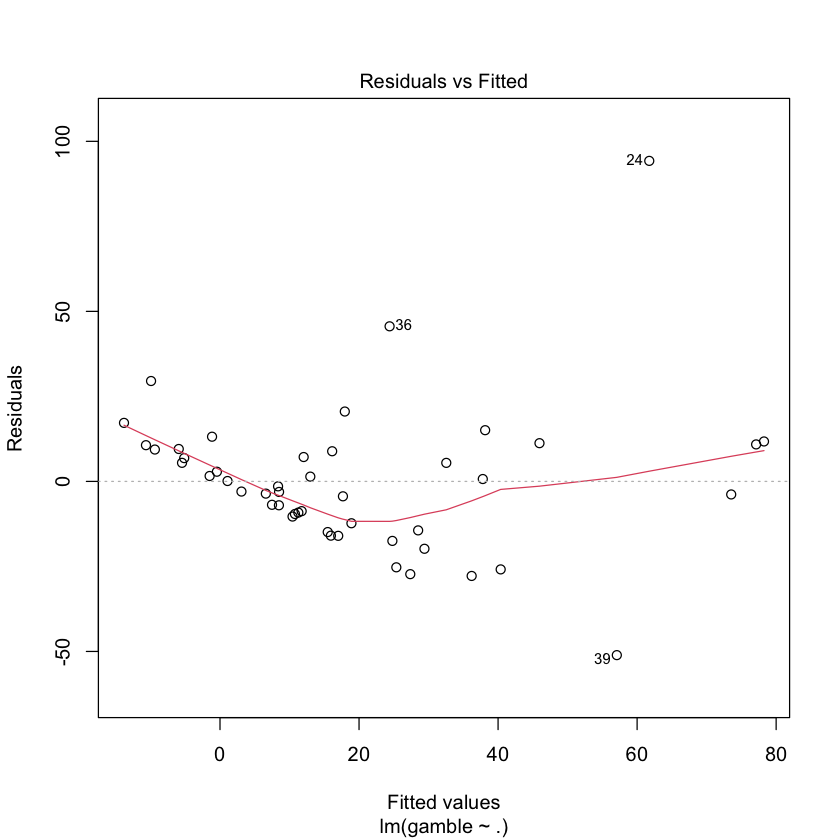

In [4]:
plot(lmod, which = 1)  # Residual vs Fitted plot

### Observations
- There is a fanning out in the residuals, suggesting the variance of the residuals increases for larger fitted values (possible heteroscedasticity).

We then split residuals into two groups based on the median value of `teengamb$gamble` and use `var.test` to compare their variances:

In [5]:
residuals <- resid(lmod)
med_gamble <- median(teengamb$gamble)

group1 <- residuals[teengamb$gamble <= med_gamble]
group2 <- residuals[teengamb$gamble > med_gamble]

var.test(group1, group2)


	F test to compare two variances

data:  group1 and group2
F = 0.32168, num df = 23, denom df = 22, p-value = 0.00913
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.1372256 0.7480403
sample estimates:
ratio of variances 
         0.3216804 


A small p-value here indicates we reject the null hypothesis of equal variances.

#### Residuals vs. Income

Because **income** is the most significant predictor, we also examine a residuals-versus-income plot:

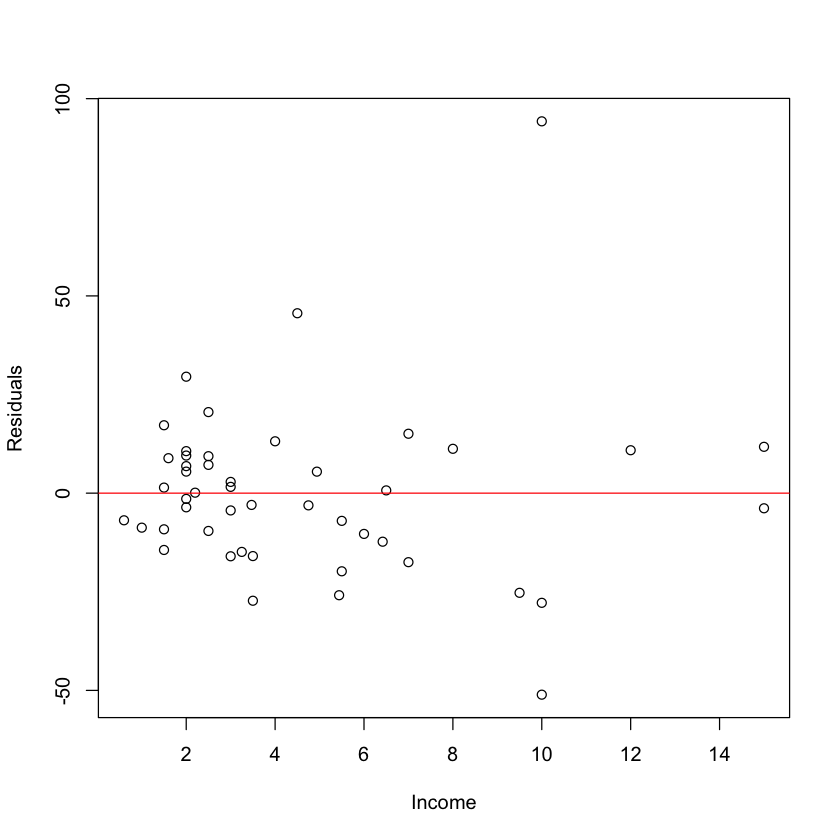

In [6]:
plot(teengamb$income, residuals,
     xlab = "Income", ylab = "Residuals")
abline(h = 0, col = 'red')

We similarly split fitted values at the median of `income` and perform another F-test:

In [7]:
fitted_values <- predict(lmod)
lower_group <- residuals[fitted_values < median(teengamb$income)]
higher_group <- residuals[fitted_values >= median(teengamb$income)]

var.test(lower_group, higher_group)


	F test to compare two variances

data:  lower_group and higher_group
F = 0.13243, num df = 11, denom df = 34, p-value = 0.00107
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.05520152 0.40938037
sample estimates:
ratio of variances 
         0.1324295 


Again, a small p-value suggests a violation of constant variance.

<br>

## Checking the Normality Assumption

Next, we want the distribution of errors to be approximately normal. We check this visually with a histogram and Q-Q plot:

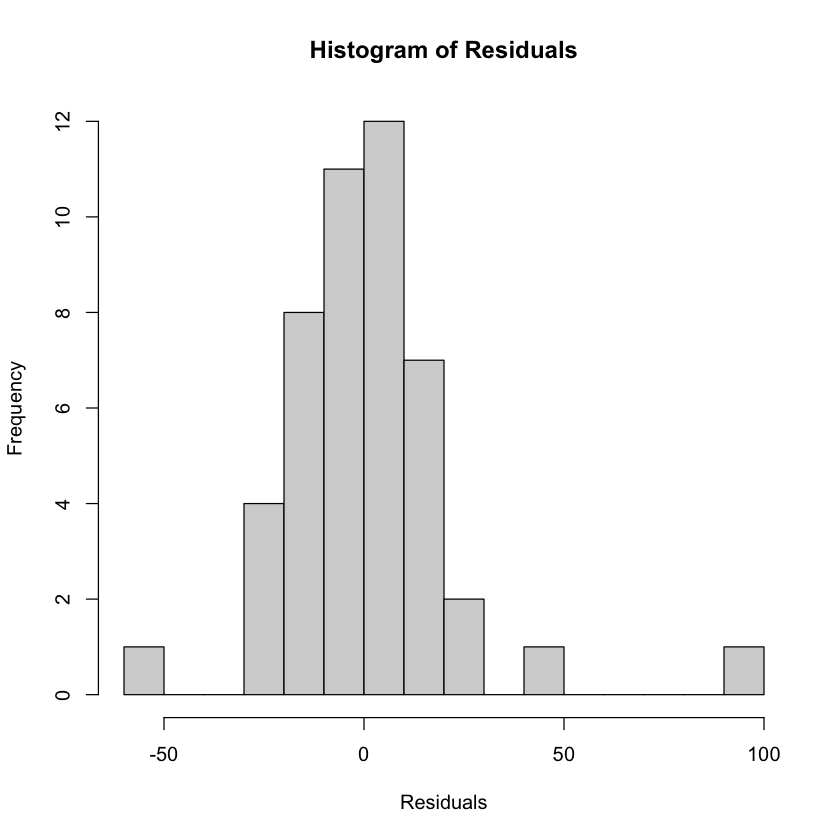

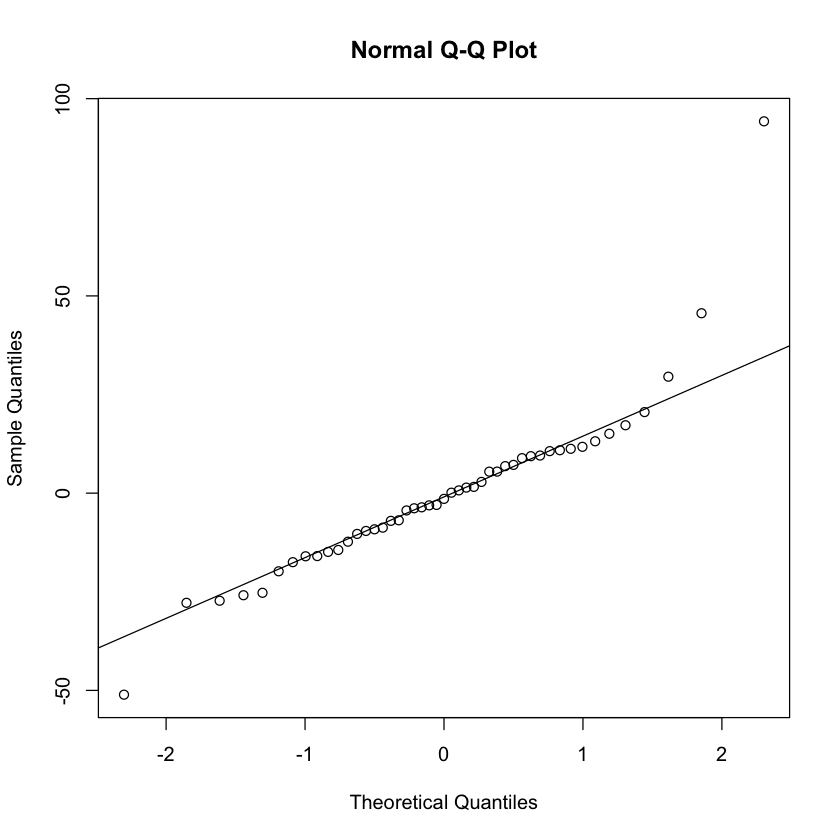

In [8]:
hist(residuals, breaks = 20, 
     main = "Histogram of Residuals", 
     xlab = "Residuals")

qqnorm(residuals)
qqline(residuals)

### Observations
- The histogram appears roughly bell-shaped but shows some heavy tails.
- The Q-Q plot confirms heavier-than-expected tails, with some extreme positive residuals and a few extreme negatives.

We use two formal normality tests:

In [9]:
shapiro.test(residuals)
ks.test(residuals, "pnorm")


	Shapiro-Wilk normality test

data:  residuals
W = 0.86839, p-value = 8.16e-05



	Exact one-sample Kolmogorov-Smirnov test

data:  residuals
D = 0.48794, p-value = 7.761e-11
alternative hypothesis: two-sided


Both tests yield small p-values, rejecting the null of normality.

<br>

## Identifying High Leverage Points

High leverage points are observations that lie far from the “center” of the predictors. We examine the diagonal of the hat matrix:

In [10]:
# Calculate leverage values
leverage_values <- lm.influence(lmod)$hat

# Create a data frame
lev_df <- data.frame(obs = 1:nrow(teengamb),
                     leverage = leverage_values)
lev_df <- lev_df[order(-lev_df$leverage), ]

# Threshold for high leverage
mean_lev <- mean(leverage_values)
high_leverage_df <- lev_df[lev_df$leverage > 2 * mean_lev, ]
high_leverage_df

,obs,leverage
,<int>,<dbl>
35,35,0.3118029
42,42,0.3016088
31,31,0.2395031
33,33,0.2213439


We see four high leverage points that exceed twice the mean leverage. For a quick visualization, a half-normal plot:

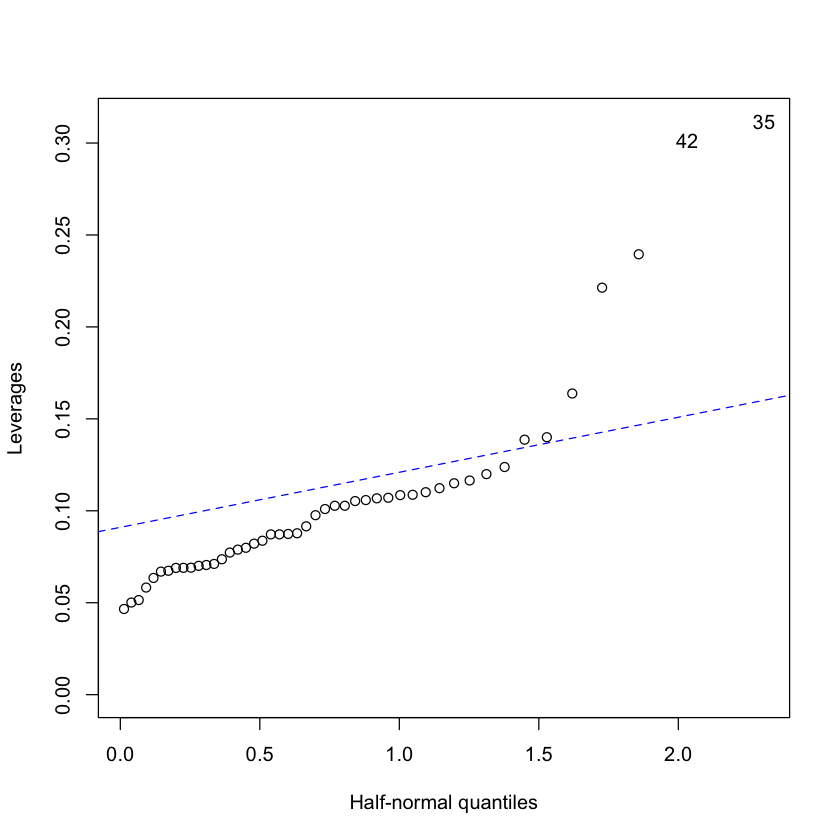

In [11]:
obs <- 1:nrow(teengamb)
halfnorm(leverage_values, labs = obs, 
         ylab = "Leverages")
qqline(leverage_values, distribution = qnorm, 
       col = "blue", lty = 2)

<br>

## Identifying Outliers with Studentized Residuals

Outliers are points where the observed response is far from the model’s predicted value. We examine the studentized residuals (also called externally studentized). Then, we apply a Bonferroni correction for multiple testing:

In [12]:
stud_res <- rstudent(lmod)
abs_stud <- abs(stud_res)

# Sort by magnitude
stud_df <- data.frame(obs = 1:length(stud_res),
                      studentized = stud_res,
                      abs_stud = abs_stud)
stud_df <- stud_df[order(-stud_df$abs_stud), ]
head(stud_df)

# Bonferroni-corrected threshold
n <- nrow(teengamb)
df <- lmod$df.residual
alpha <- 0.05
bonf_alpha <- alpha / n

critical_value <- qt(1 - bonf_alpha/2, df)
critical_value

,obs,studentized,abs_stud
,<int>,<dbl>,<dbl>
24,24,6.016116,6.016116
39,39,-2.506090,2.506090
36,36,2.144826,2.144826
5,5,1.418583,1.418583
18,18,-1.317398,1.317398
23,23,-1.252647,1.252647


[1] 3.516461

Any studentized residual that exceeds this critical value in absolute magnitude is considered an outlier. We find one data point (obs #24) that substantially exceeds this threshold.

#### Plotting Actual vs. Predicted to Highlight Outlier

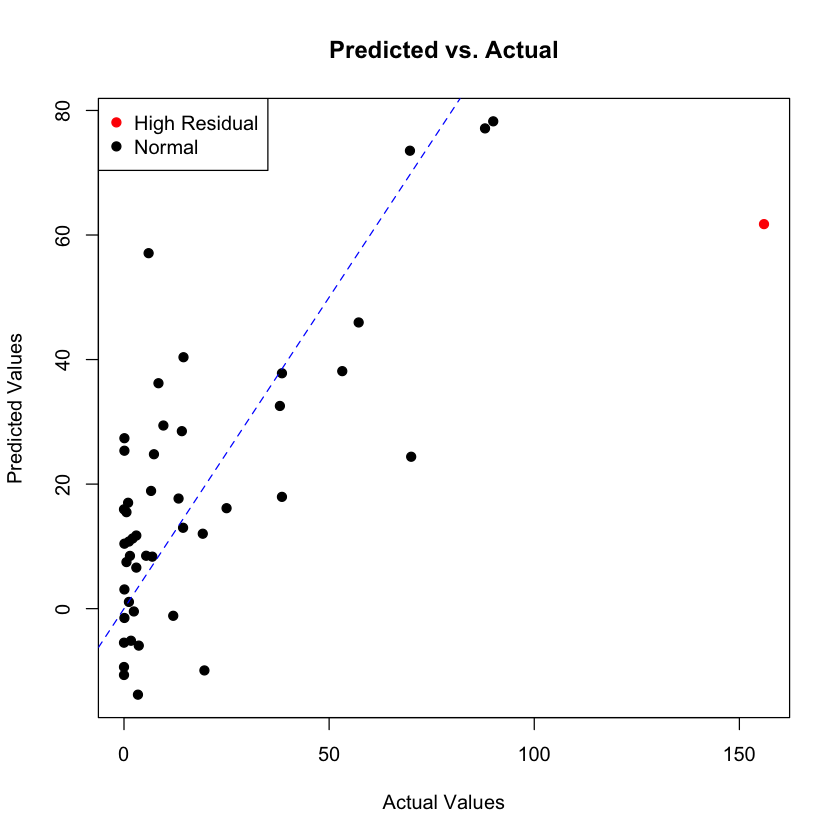

In [13]:
actual <- teengamb$gamble
predicted <- predict(lmod)

high_resid_pts <- abs_stud > critical_value

plot(actual, predicted,
     xlab = "Actual Values", ylab = "Predicted Values",
     main = "Predicted vs. Actual",
     pch = 19,
     col = ifelse(high_resid_pts, "red", "black"))
abline(a = 0, b = 1, col = "blue", lty = 2)
legend("topleft", legend = c("High Residual", "Normal"),
       col = c("red", "black"), pch = 19)

<br>

## Influential Observations

While outliers are about large residuals, “influence” focuses on how much a point changes the regression when removed. A common measure is Cook’s Distance:

24 39 
24 39

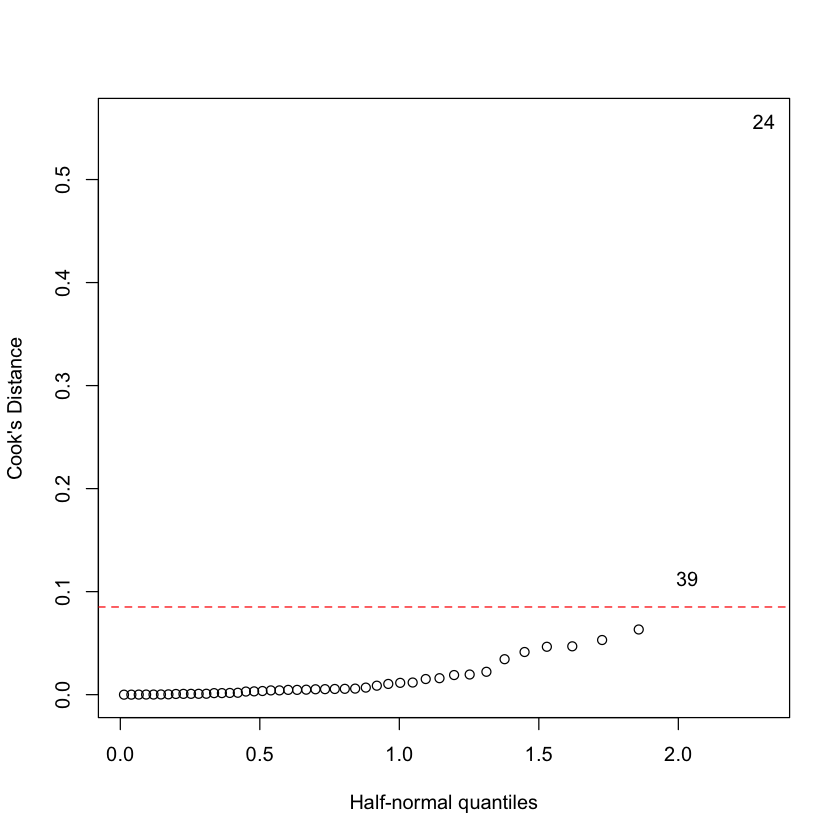

In [14]:
cook <- cooks.distance(lmod)
threshold_cook <- 4 / n  # Common rule-of-thumb cutoff

halfnorm(cook, labs = obs, ylab = "Cook's Distance")
abline(h = threshold_cook, col = "red", lty = 2)

high_cook_obs <- which(cook > threshold_cook)
high_cook_obs

We see two points that exceed this cutoff. Point #24 matches our outlier from before, and point #39 shows moderate Cook’s Distance despite not having a massive studentized residual or extremely high leverage.

### Effect of Removing Influential Points

We can refit the model omitting each influential point and compare parameter estimates:

In [15]:
# Remove observation 24
teengamb_no24 <- teengamb[-24, ]
lmod_no24 <- lm(gamble ~ ., data = teengamb_no24)
summary(lmod_no24)


Call:
lm(formula = gamble ~ ., data = teengamb_no24)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.999  -8.102  -0.491   8.600  46.688 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7.6306    12.9251   0.590   0.5582    
sex         -16.2986     6.1335  -2.657   0.0112 *  
status        0.1739     0.2083   0.835   0.4088    
income        4.3312     0.7636   5.672 1.26e-06 ***
verbal       -1.8019     1.6137  -1.117   0.2707    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.74 on 41 degrees of freedom
Multiple R-squared:  0.5682,	Adjusted R-squared:  0.526 
F-statistic: 13.49 on 4 and 41 DF,  p-value: 4.225e-07


Compare with the original model:

In [16]:
coef_diff <- coef(lmod) - coef(lmod_no24)
r2_diff   <- summary(lmod)$r.squared - summary(lmod_no24)$r.squared
sigma_diff <- summary(lmod)$sigma - summary(lmod_no24)$sigma

coef_diff
r2_diff
sigma_diff

(Intercept)         sex      status      income      verbal 
 14.9250525  -5.8197401  -0.1216380   0.6307326  -1.1576267

[1] -0.04145291

[1] 5.953447

Observation #24 strongly influences the intercept, sex coefficient, and the model’s residual standard error.

In [17]:
# Remove observation 39
teengamb_no39 <- teengamb[-39, ]
lmod_no39 <- lm(gamble ~ ., data = teengamb_no39)
summary(lmod_no39)

# Compare with original
coef_diff_39 <- coef(lmod) - coef(lmod_no39)
r2_diff_39   <- summary(lmod)$r.squared - summary(lmod_no39)$r.squared
sigma_diff_39 <- summary(lmod)$sigma - summary(lmod_no39)$sigma

coef_diff_39
r2_diff_39
sigma_diff_39


Call:
lm(formula = gamble ~ ., data = teengamb_no39)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.471 -10.960  -2.027   7.452  90.027 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.7620    16.2239   1.280  0.20784    
sex         -22.5954     7.7414  -2.919  0.00568 ** 
status        0.1255     0.2666   0.471  0.64025    
income        5.5332     0.9930   5.572 1.75e-06 ***
verbal       -3.3774     2.0540  -1.644  0.10777    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.39 on 41 degrees of freedom
Multiple R-squared:  0.588,	Adjusted R-squared:  0.5478 
F-statistic: 14.63 on 4 and 41 DF,  p-value: 1.667e-07


(Intercept)         sex      status      income      verbal 
 1.79366329  0.47705107 -0.07327077 -0.57122299  0.41789394

[1] -0.06123735

[1] 1.30458

The changes are smaller than for observation #24, but still non-trivial (e.g., the income coefficient changes by about 0.57).

<br>

## Checking Model Structure

Added-variable plots (partial regression plots) and component+residual plots help visualize whether each predictor has a linear relationship with the response and whether any observations stand out.

### Added-Variable Plots

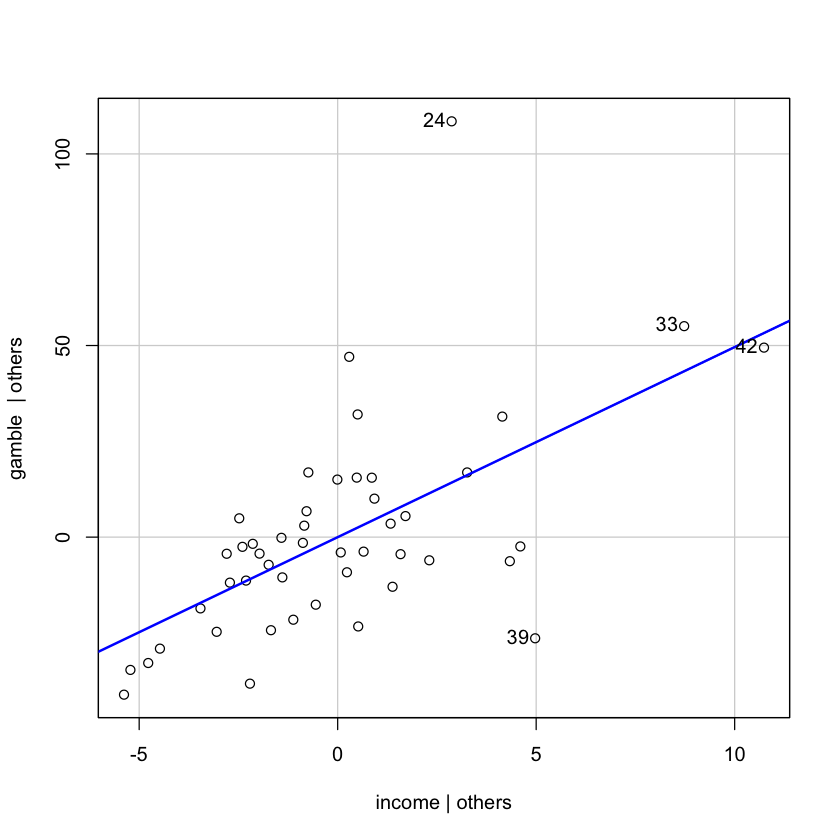

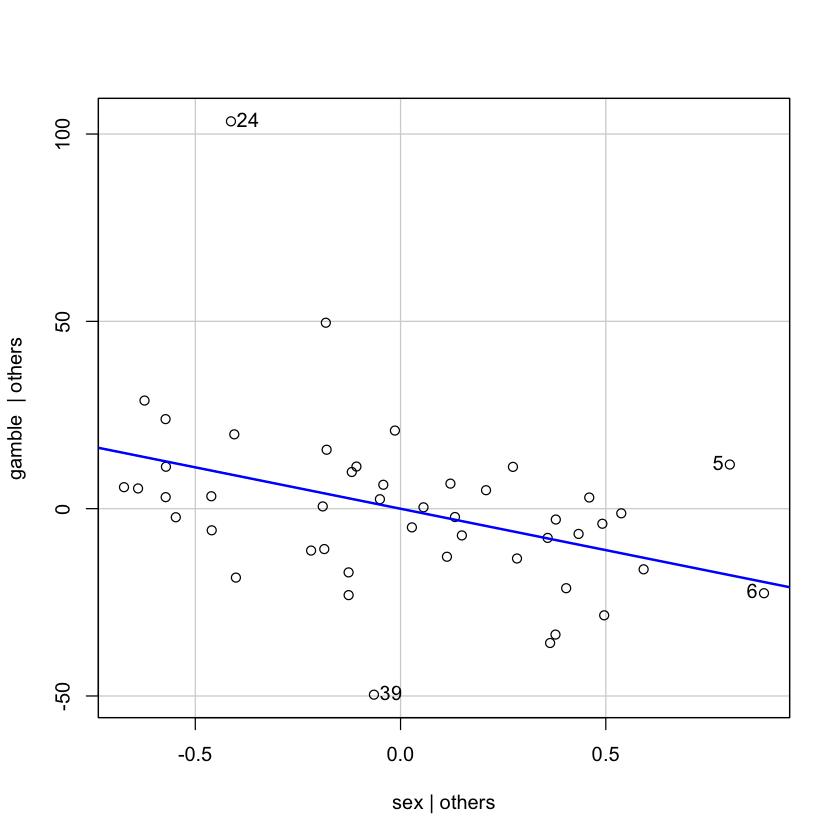

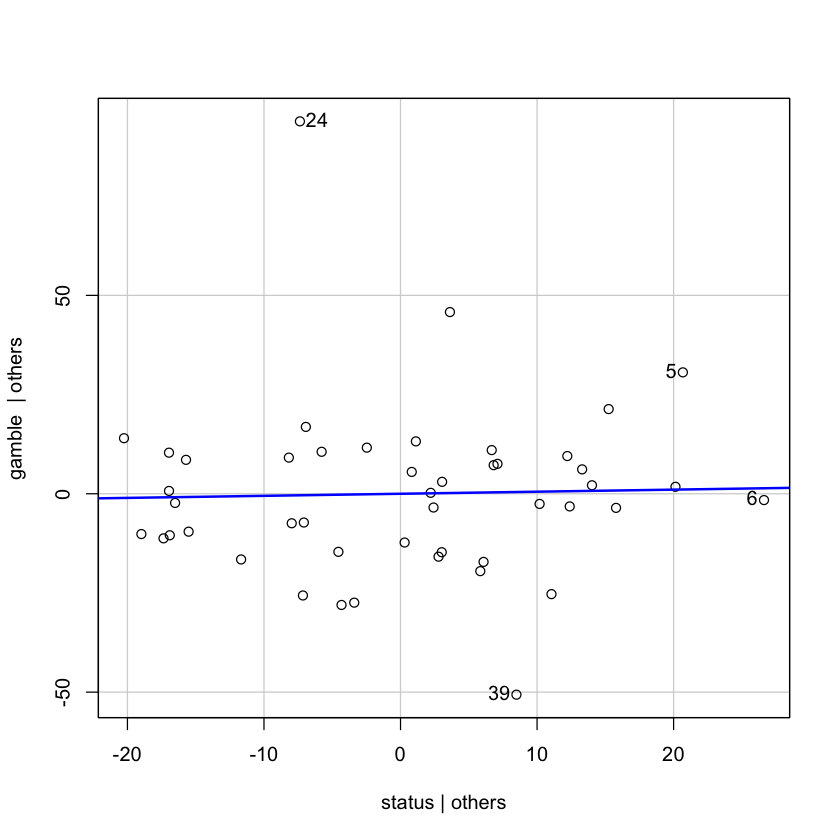

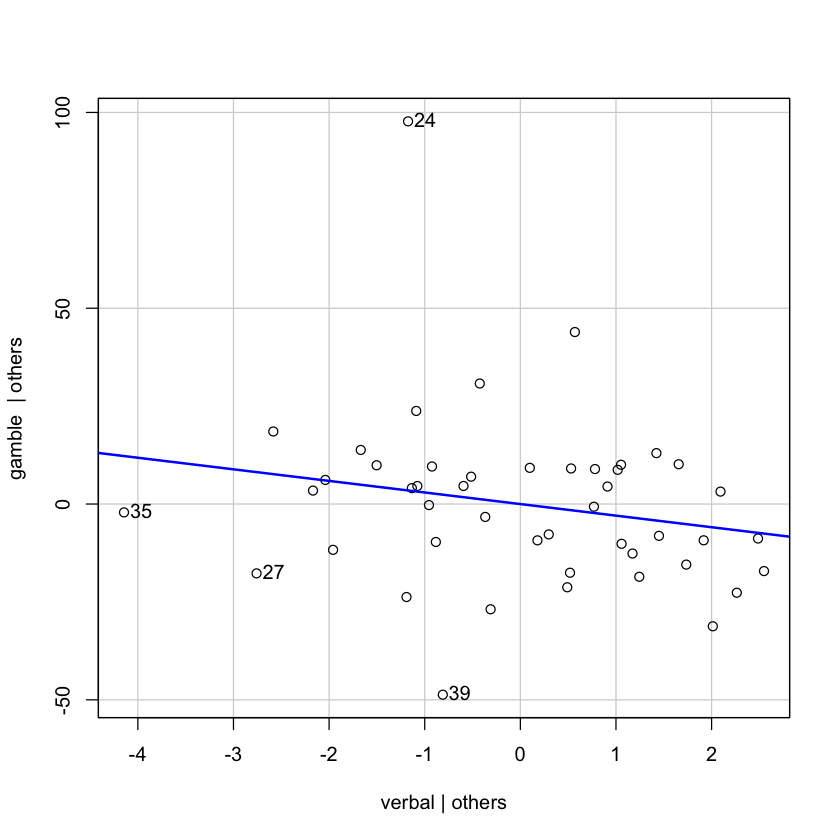

In [18]:
avPlots(lmod, terms = ~ income, ask = FALSE)
avPlots(lmod, terms = ~ sex,    ask = FALSE)
avPlots(lmod, terms = ~ status, ask = FALSE)
avPlots(lmod, terms = ~ verbal, ask = FALSE)

We see points #24 and #39 are distinct in many plots, consistent with earlier findings.

### Component + Residual Plots

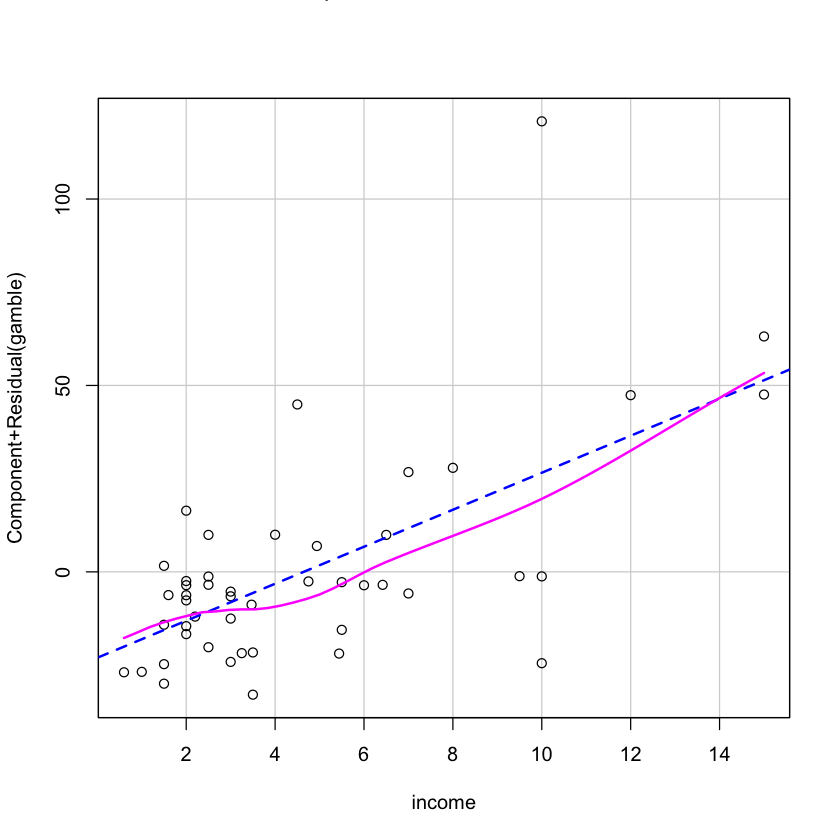

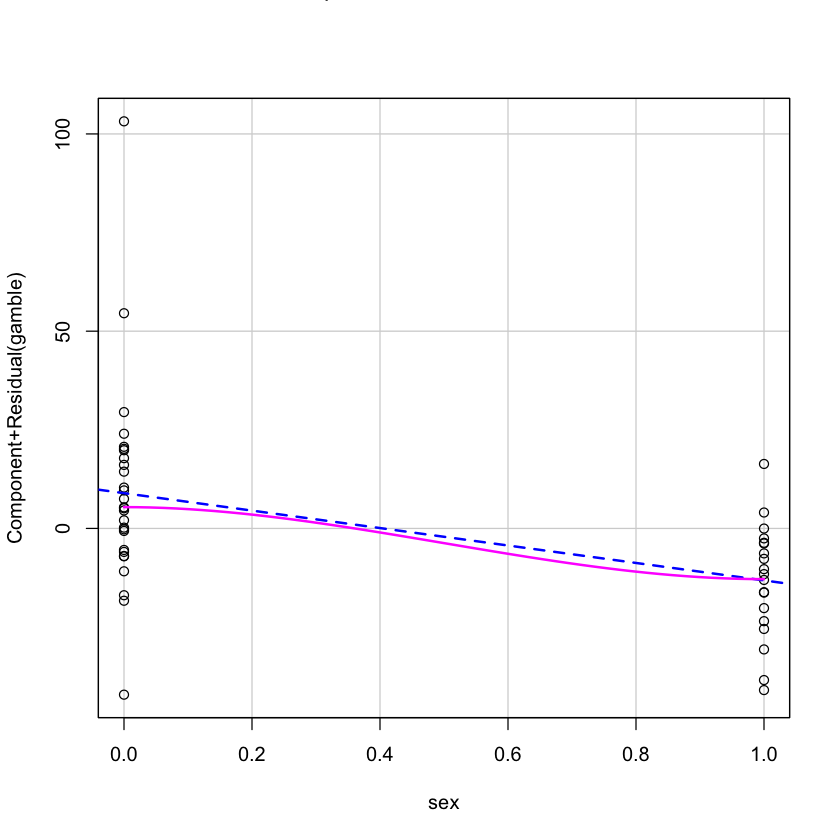

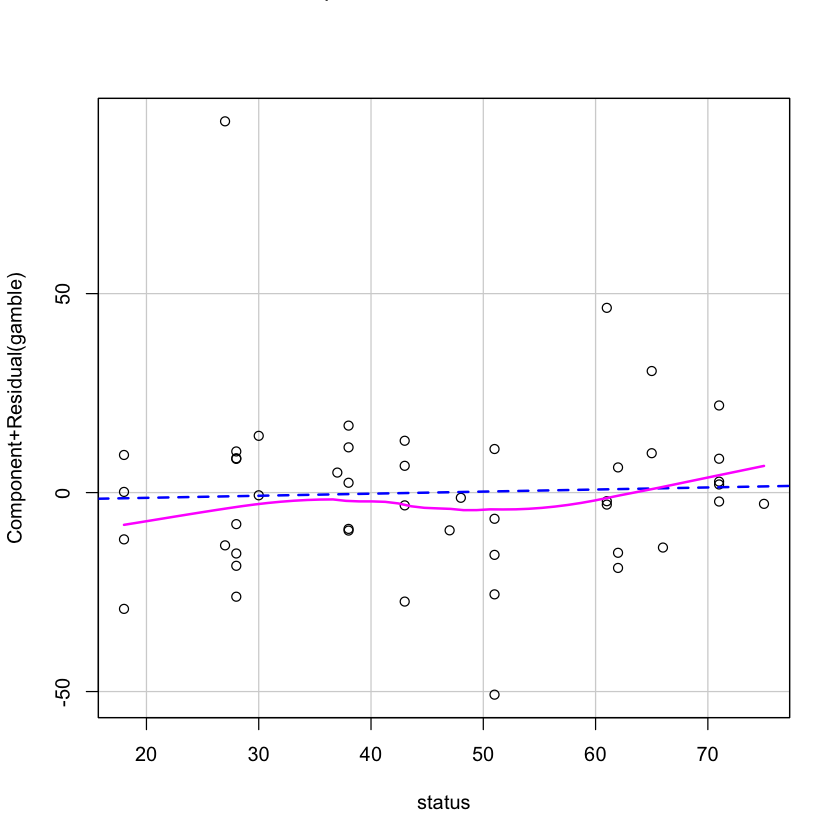

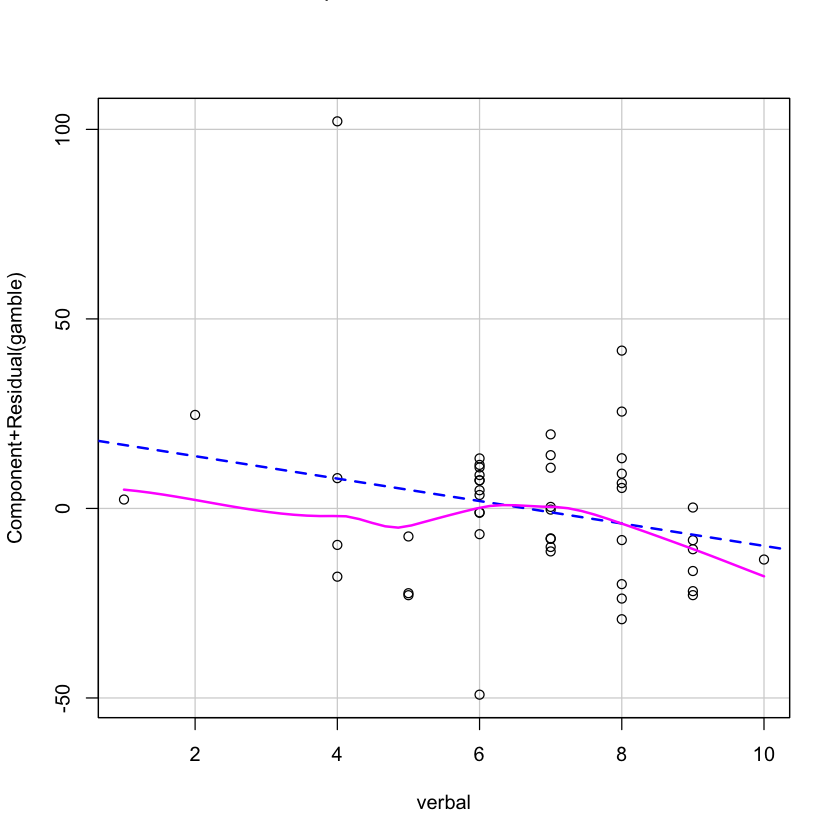

In [19]:
suppressWarnings(crPlots(lmod, terms = ~ income, ask=FALSE))
suppressWarnings(crPlots(lmod, terms = ~ sex, ask=FALSE))
suppressWarnings(crPlots(lmod, terms = ~ status, ask=FALSE))
suppressWarnings(crPlots(lmod, terms = ~ verbal, ask=FALSE))

These partial residual plots confirm no strong sign of nonlinearity, with the relationship to **income** being the clearest.

<br>

## Conclusion

From our diagnostic analysis:

- **Constant Variance**: Tests and plots suggest clear heteroscedasticity, especially at higher fitted values and higher incomes.
- **Normality**: Residuals show heavier tails than a normal distribution. Formal tests (Shapiro-Wilk and Kolmogorov-Smirnov) reject normality.
- **High Leverage**: Four points exceed twice the mean leverage. They largely differ in `income` (and in some cases `status` or `verbal`).
- **Outliers**: One particularly large outlier (#24) strongly deviates from the fitted model prediction (studentized residual ~6).
- **Influential Points**: Observations #24 and #39 have high Cook’s Distance. Removing #24 notably changes the model intercept, slope estimates, and residual standard error. Removing #39 has a more moderate effect.

In summary, the model’s assumptions are not fully met. The presence of heteroscedasticity and non-normality of residuals suggests we may need transformations or more robust modeling techniques. Observations #24 and #39 warrant special attention due to their influence on the model.

<br>

---

**Reference**:  
Ide-Smith & Lea (1988). *Journal of Gambling Behavior*, 4, 110–118.

<br>